In [51]:
import pandas as pd
import filedialpy as fp
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [7]:
df = pd.read_csv(fp.openFile(), encoding="latin-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,88000,01-12-2010 08:26,700.00,17850.0,United Kingdom
1,536365,71053,REGENCY CAKESTAND 3 TIER,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [9]:
df.dropna(subset=['CustomerID','Quantity','UnitPrice'])
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]

In [15]:
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="mixed")
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days

customer_data = df.groupby('CustomerID').agg(
                        TotalSpend = ('TotalSpend', 'sum'),
                        Frequency = ('InvoiceNo', 'nunique'),
                        Recency = ('Recency', 'min'),
).reset_index()

In [21]:
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['TotalSpend', 'Frequency','Recency']])

In [25]:
inertia = []
K_range = range(1,11)
for k in K_range:
    Kmeans = KMeans(n_clusters = k, random_state = 1234)
    Kmeans.fit(customer_data_scaled)
    inertia.append(Kmeans.inertia_)

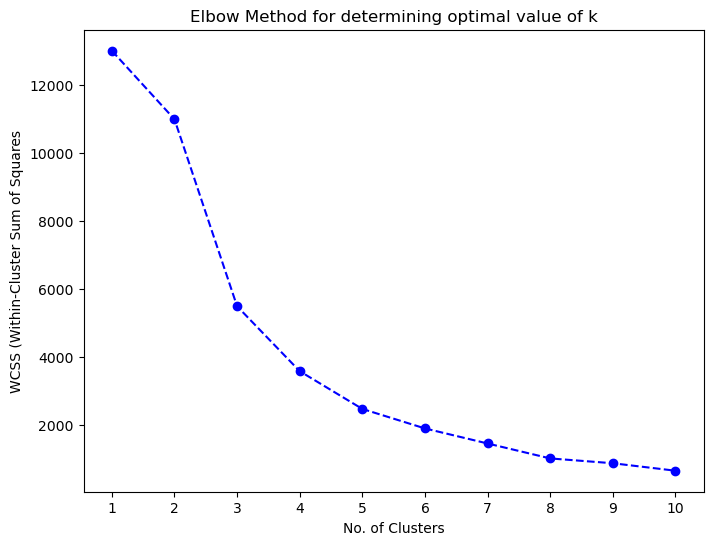

In [31]:
plt.figure(figsize=(8,6))
plt.plot(K_range, inertia, marker='o', linestyle="--", color='b')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares')
plt.title('Elbow Method for determining optimal value of k')
plt.xticks(K_range)
plt.show()

In [33]:
optimal_k = 4
Kmeans = KMeans(n_clusters = optimal_k, random_state = 1234)
customer_data['cluster'] = Kmeans.fit_predict(customer_data_scaled)

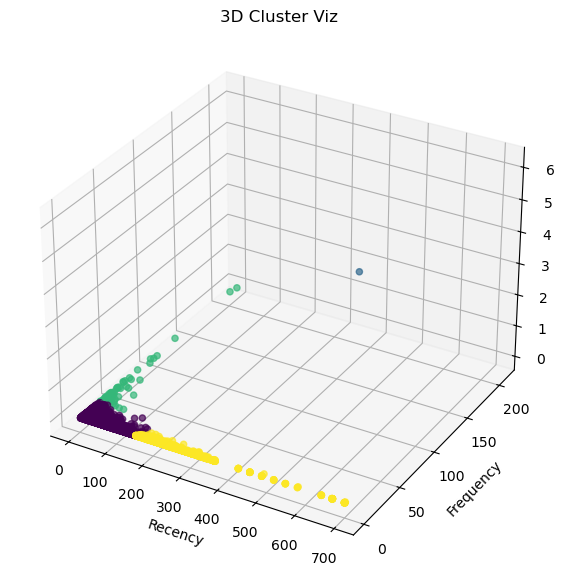

In [43]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection = '3d')
scatter = ax.scatter(customer_data['Recency'], customer_data['Frequency'],
                     customer_data['TotalSpend'], c = customer_data['cluster'], 
                     cmap = 'viridis', alpha = 0.7)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Cluster Viz')
plt.show()

In [59]:
sil_score = silhouette_score(customer_data_scaled, Kmeans.labels_)
print(f'SIlhouette Score: {sil_score:.3f}')

SIlhouette Score: 0.580


In [63]:
cluster_size = customer_data['cluster'].value_counts()
print('No. of customer per cluster: \n', cluster_size)

No. of customer per cluster: 
 cluster
0    3114
3    1153
2      70
1       1
Name: count, dtype: int64


In [69]:
centers_transformed = scaler.inverse_transform(Kmeans.cluster_centers_)
cluster_centroids = customer_data.groupby('cluster').mean()
print('Cluster Centroids: \n', cluster_centroids)

Cluster Centroids: 
            CustomerID    TotalSpend  Frequency     Recency
cluster                                                   
0        15296.076750  1.866732e+03   4.364804   50.131021
1        17850.000000  6.160538e+07  34.000000  667.000000
2        15197.700000  3.486618e+04  44.971429   12.185714
3        15316.130095  5.658102e+02   1.524718  263.870772


In [75]:
cluster_std = customer_data.groupby('cluster').std()
print('Cluster std: \n', cluster_std)

Cluster std: 
           CustomerID    TotalSpend  Frequency     Recency
cluster                                                  
0        1713.358619   4849.582645   4.020649   39.963895
1                NaN           NaN        NaN         NaN
2        1833.039784  52872.584195  34.053654   13.360436
3        1737.963540   2341.314429   0.978743  106.509307


In [83]:
cluster_percent = (cluster_size / cluster_size.sum()) * 100
print('Percentage of Customers in each cluster: \n', cluster_percent)

Percentage of Customers in each cluster: 
 cluster
0    71.784232
3    26.579069
2     1.613647
1     0.023052
Name: count, dtype: float64
